# **INTEL MULTICLASS IMAGE CLASSIFICATION**

In [ ]:
# Import module provided by Google Colab for file upload needs
from google.colab import files
files.upload()

In [ ]:
# Download kaggle dataset and unzip the file
# Source dataset intel : puneet6060/intel-image-classification
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d annisarizki/intel-image-dataset
!unzip intel-image-dataset.zip

In [ ]:
# Import the required modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import random
from random import sample
from collections import defaultdict
import collections
import math 
import os
import cv2 
from glob import glob
from PIL import Image
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle  
import shutil
from shutil import copy
from shutil import copytree, rmtree
from tqdm.notebook import tqdm as tq
from tqdm import tqdm

import tensorflow as tf      
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical   
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
 
import datetime
import time

import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

np.random.seed(123)

# **DEVELOPING DATASETS INTO DATA TRAINING, VALIDATION, AND TESTING**

In [ ]:
mypath = "seg-train/seg_train/"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        labels.append(path.split('/')[-1])        
        file_name.append(name)

In [ ]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

In [ ]:
# Variables used in this data separation where x = data path and y = data labels
X= df['path']
y= df['labels']

# Split the initial dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# Split the initial dataset into train and test data
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=300)

In [ ]:
# Integrate into each dataframe
df_tr = pd.DataFrame({'path':X_train,
                      'labels':y_train,
                      'set':'train'})

df_te = pd.DataFrame({'path':X_test,
                      'labels':y_test,
                      'set':'test'})

df_val = pd.DataFrame({'path':X_val,
                      'labels':y_val,
                      'set':'val'})

In [ ]:
# Print the results above to see the length of the training, validation and testing data sizes
print('train size', len(df_tr))
print('val size', len(df_val))
print('test size', len(df_te))

train size 11227
val size 1404
test size 1403


In [ ]:
# See the proportions in each set whether it's ok or there is still something you want to change
df_all = df_tr.append([df_te, df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','labels']).size(),'\n')

print('===================================================== \n')

# Check the sample data
df_all.sample(5)


set    labels   
test   buildings     214
       forest        217
       glacier       243
       mountain      246
       sea           221
       street        262
train  buildings    1766
       forest       1841
       glacier      1910
       mountain     1996
       sea          1839
       street       1875
val    buildings     211
       forest        213
       glacier       251
       mountain      270
       sea           214
       street        245
dtype: int64 




,path,labels,set
6929,seg_train/seg_train/street/11060.jpg,street,train
490,seg_train/seg_train/buildings/12263.jpg,buildings,train
2808,seg_train/seg_train/forest/8166.jpg,forest,train
1893,seg_train/seg_train/forest/11149.jpg,forest,train
3597,seg_train/seg_train/forest/3914.jpg,forest,train


In [ ]:
# Calls the original dataset containing the entire image data that matches the label
datasource_path = "seg-train/seg_train/"
# Create a Dataset variable, which will later accommodate the data that has been divided into training and testing data
dataset_path = "Dataset/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    
    # Detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])            
    
    # Create a folder destination directory
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))
    
    # Specify the destination of the file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)
    
    # Copy files from source to destination
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Results saved in zip format
!zip -r INTEL-IMAGE.zip Dataset

# **EDA AND VISUALIZATION SAMPLE IMAGE OF EACH CLASS**

In [ ]:
intel_image = {}

path = "Dataset"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "train")
for i in os.listdir(path_train):
    intel_image[i] = os.listdir(os.path.join(path_train, i))

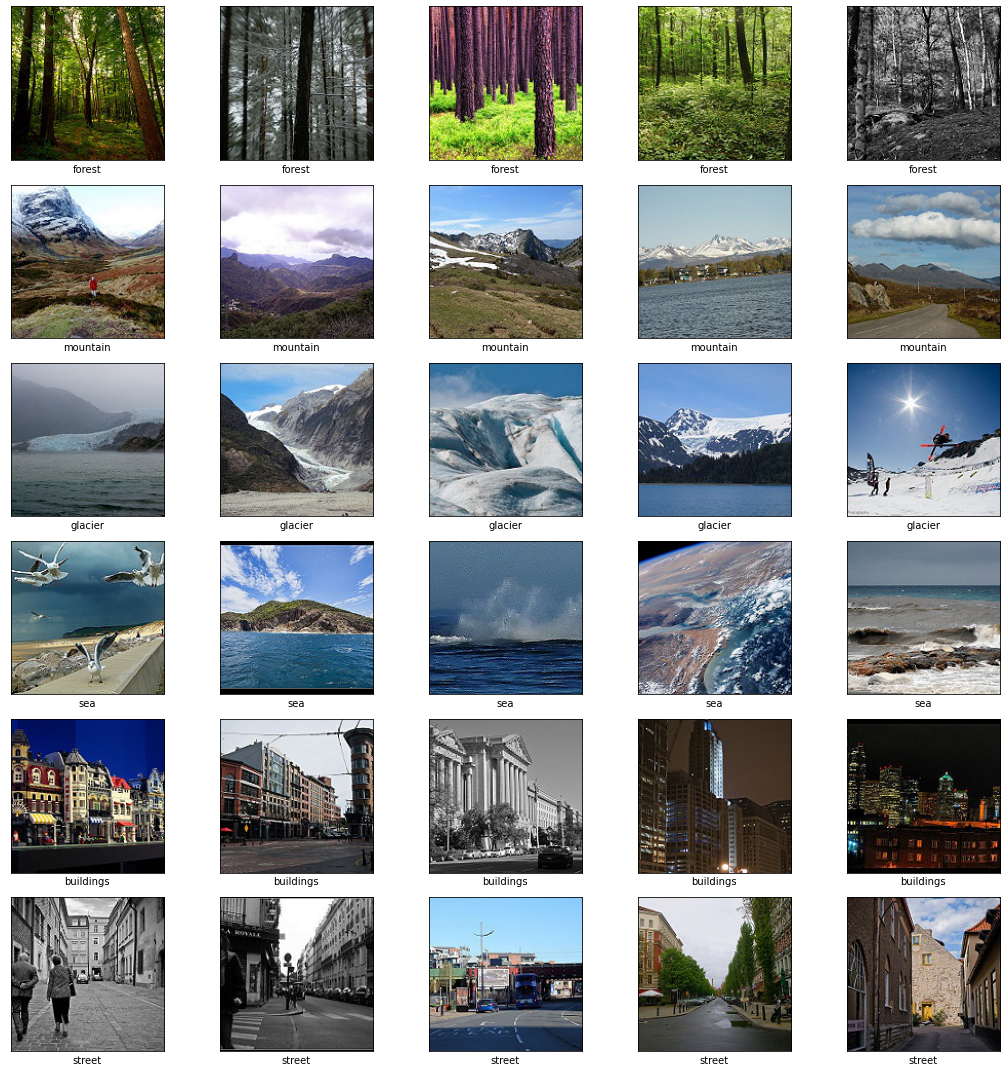

In [ ]:
# Randomly display 5 images under each of the 6 categories from the training data.
# You will see different images each time.

path_train= 'Dataset/train/'

fig, axs = plt.subplots(len(intel_image.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(intel_image[item], 5)
    
    for j, image in enumerate(images):
        img = Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()
fig.savefig('sample-train.png')

In [ ]:
filename = []
labels = []
fullpath = []
for path, subdirs, files in os.walk(path_train):
    for name in files:
        fullpath.append(os.path.join(path, name)) 
        labels.append(path.split('/')[-1])        
        filename.append(name)
df = pd.DataFrame({"path":fullpath,'filename':filename,"labels":labels})

In [ ]:
df_viz = df.groupby(["labels"])["labels"].count().reset_index(name="count")
df_viz

,labels,count
0,buildings,1766
1,forest,1841
2,glacier,1910
3,mountain,1996
4,sea,1839
5,street,1875


In [ ]:
fig = px.bar(df_viz, x = "labels", y = "count", width=600, height=400)
fig.show()

fig2 = px.pie(df_viz, values='count', names='labels', title='Proportion of each observed category', width=600, height=400)
fig2.show()

# **FEATURE EXTRACTION WITH BOTTLENECK Vgg16**

In [ ]:
# Dimensions of our image
img_width, img_height = 150, 150  

# Variable to accommodate bottleneck results
top_model_weights_path = 'bottleneck_intel_model.h5'  

train_data_dir = 'Dataset/train/'  
val_data_dir = 'Dataset/val/'
test_data_dir = 'Dataset/test/'
    
epochs = 20  # Number of epochs to train top model 
batch_size = 64  # Number of batch size to train top model 

In [ ]:
# Save bottleneck features
model = VGG16(include_top=False, weights='imagenet')  
    
datagen = ImageDataGenerator(rescale=1. / 255) 
    
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
    
nb_train_samples = len(generator.filenames)  
    
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
    
bottleneck_features_train = model.predict(  
     generator, predict_size_train) 
    
print(bottleneck_features_train.shape)
    
np.save('bottleneck_features_train.npy', bottleneck_features_train) 
    
generator = datagen.flow_from_directory(  
     val_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
    
nb_validation_samples = len(generator.filenames)  
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
    
bottleneck_features_validation = model.predict(  
    generator, predict_size_validation)  

print(bottleneck_features_validation.shape)
    
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)


generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
    
nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
    
bottleneck_features_test = model.predict(  
    generator, predict_size_test)  

print(bottleneck_features_test.shape)
    
np.save('bottleneck_features_test.npy', bottleneck_features_test)

58900480/58889256 [==============================] - 0s 0us/step
Found 11227 images belonging to 6 classes.
(11227, 4, 4, 512)
Found 1404 images belonging to 6 classes.
(1404, 4, 4, 512)
Found 1403 images belonging to 6 classes.
(1403, 4, 4, 512)


# **IMAGE DATA GENERATOR**

In [ ]:
# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False    
)

validation_generator=train_datagen.flow_from_directory(
      val_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False
)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
) 

Found 11227 images belonging to 6 classes.
Found 1404 images belonging to 6 classes.
Found 1403 images belonging to 6 classes.


In [ ]:
nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  
    
# Load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
    
# Get the class labels for the training data, in the original order  
train_labels = train_generator.classes
    
# Convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  
train_labels[0] # Array of 6 elements


nb_validation_samples = len(validation_generator.filenames)  
validation_data = np.load('bottleneck_features_validation.npy')  
    
validation_labels = validation_generator.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 
validation_labels.shape
validation_labels[0] # Array of 6 elements

array([1., 0., 0., 0., 0., 0.], dtype=float32)

# **BUILD MODEL AND DO TRAINING TO GET THE RESULT OF FEATURE EXTRACTION**

In [ ]:
# Build the top model and start training
checkpointer = ModelCheckpoint('best_model.hdf5',save_best_only = True,verbose = 1)
    
model = Sequential()  
# NOTE the shape given is the shape of the train_data saved in bottleneck features
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dense(6, activation='softmax'))
# Summary the architecture model
model.summary()
    
model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy']) 
    
history = model.fit(train_data, train_labels,  
                    epochs=epochs,  
                    batch_size=batch_size,  
                    validation_data=(validation_data, validation_labels),
                    callbacks = [checkpointer])  
    
model.save_weights(top_model_weights_path)
    
(eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total params: 3,078
Trainable params: 3,078
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
176/176 [==============================] - 1s 4ms/step - loss: 1.1243 - accuracy: 0.6671 - val_loss: 0.7725 - val_accuracy: 0.7749

Epoch 00001: val_loss improved from inf to 0.77251, saving model to best_model.hdf5
Epoch 2/20
176/176 [==============================] - 1s 3ms/step - loss: 0.6525 - accuracy: 0.7983 - val_loss: 0.5826 - val_accuracy: 0.8177

Epoch 00002: val_loss improved from 0.77251 to 0.58260, saving model to best_model.hdf5
Epoch 3/20
176/176 [==============================] - 1s

# **BUILD MODEL FINETUNE VGG16 AND DO TRAINING**

In [ ]:
def create_model():  
    input_tensor = Input(shape=(img_width,img_height,3))
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    top_model = Sequential()  
    top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(6, activation='softmax')) 
    top_model.load_weights(top_model_weights_path)

    # Loading the weights of bottle neck features model
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    return model

# **RESET IMAGE DATA GENERATOR FOR FINETUNING**

In [ ]:
def img_generator(train_data_dir,val_data_dir,test_data_dir):
    train_datagen = ImageDataGenerator(rescale = 1./255)
    train_generator=train_datagen.flow_from_directory(
          train_data_dir,
          target_size=(img_width, img_height),
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=False
    )
    validation_generator=train_datagen.flow_from_directory(
          val_data_dir,
          target_size=(img_width, img_height),
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=False    
    )
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_dir, 
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    ) 
    return train_generator,validation_generator,test_generator

In [ ]:
print('Get ImageDataGenerator')
train_generator,valid_generator,test_generator = img_generator(train_data_dir,val_data_dir,test_data_dir)

print('Run pretrained model')
vgg_intel_model = create_model()
for layer in vgg_intel_model.layers[:15]:
    layer.trainable = False

# Summary the architecture model
vgg_intel_model.summary()

best_model_finetuned_bottleneck = 'best_bottleneck_finetuned_model.hdf5'

# Create model checkpoint to save best model weights
checkpointer = ModelCheckpoint(best_model_finetuned_bottleneck,save_best_only = True,verbose = 1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                          patience=10,
                          restore_best_weights=True,
                          mode='min')

# Set the number of steps per epoch on the training data based on the calculation of the number of training data samples divided by the number of batch_size
training_steps_per_epoch = np.ceil(train_generator.samples // batch_size)
# Set the number of steps per epoch on data validation based on the calculation of the number of data validation samples divided by the number of batch_size
validation_steps_per_epoch = np.ceil(valid_generator.samples // batch_size)

# Fine-tune the model
history = vgg_intel_model.fit(train_generator,
                              steps_per_epoch=training_steps_per_epoch,
                              epochs = 20,
                              validation_data=valid_generator,
                              validation_steps=validation_steps_per_epoch,
                              callbacks=[checkpointer, early_stop])

# Evaluate model with training and validation data
(eval_loss, eval_accuracy) = vgg_intel_model.evaluate(train_generator, batch_size=batch_size, verbose=1)
(eval_loss, eval_accuracy) = vgg_intel_model.evaluate(valid_generator, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

# Save model
vgg_intel_model.save('intel_bc_finetune_vgg16.h5')  

Get ImageDataGenerator
Found 11227 images belonging to 6 classes.
Found 1404 images belonging to 6 classes.
Found 1403 images belonging to 6 classes.
Run pretrained model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D

# **VISUALIZATION OF TRAINING RESULT**

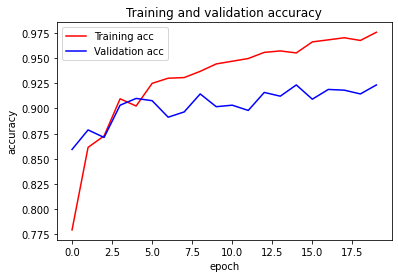

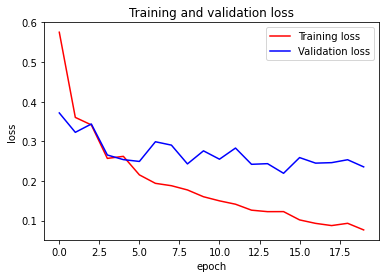




        loss  accuracy  val_loss  val_accuracy  epoch
0   0.575169  0.779540  0.371567      0.859375      0
1   0.360327  0.861417  0.322638      0.878720      1
2   0.341385  0.872794  0.343667      0.871280      2
3   0.256873  0.909612  0.265462      0.903274      3
4   0.262073  0.902446  0.253806      0.909970      4
5   0.215344  0.924931  0.249223      0.907738      5
6   0.193973  0.930037  0.298888      0.891369      6
7   0.187983  0.930664  0.290368      0.896577      7
8   0.177321  0.936845  0.242981      0.914435      8
9   0.160186  0.944196  0.275953      0.901786      9
10  0.149798  0.946878  0.254877      0.903274     10
11  0.141306  0.949566  0.282994      0.898065     11
12  0.126270  0.955657  0.241996      0.915923     12
13  0.122541  0.957090  0.243609      0.912202     13
14  0.122645  0.955120  0.219326      0.923363     14
15  0.101719  0.966049  0.258950      0.909226     15
16  0.092978  0.968109  0.244953      0.918899     16
17  0.087414  0.970169  0

In [ ]:
# Make a graph plot of the results of the accuracy of training validation and loss training validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

print('\n\n')
# Convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(history.history) 
hist_df['epoch'] = history.epoch
hist_df.to_csv('history.csv', index=None)
# Checkout result with print e.g.:    
print(hist_df)

# **TESTING WITH DATA TESTING**

[INFO] evaluating after fine-tuning network head...
{'Buildings': {'precision': 0.9497716894977168, 'recall': 0.9719626168224299, 'f1-score': 0.9607390300230946, 'support': 214}, 'Forest': {'precision': 0.9728506787330317, 'recall': 0.9907834101382489, 'f1-score': 0.9817351598173517, 'support': 217}, 'Glacier': {'precision': 0.8685258964143426, 'recall': 0.897119341563786, 'f1-score': 0.8825910931174089, 'support': 243}, 'Mountain': {'precision': 0.9, 'recall': 0.8780487804878049, 'f1-score': 0.888888888888889, 'support': 246}, 'Sea': {'precision': 0.9636363636363636, 'recall': 0.9592760180995475, 'f1-score': 0.961451247165533, 'support': 221}, 'Street': {'precision': 0.9801587301587301, 'recall': 0.9427480916030534, 'f1-score': 0.9610894941634242, 'support': 262}, 'accuracy': 0.9379900213827512, 'macro avg': {'precision': 0.9391572264066975, 'recall': 0.9399897097858116, 'f1-score': 0.9394158188626168, 'support': 1403}, 'weighted avg': {'precision': 0.9384011085755439, 'recall': 0.937

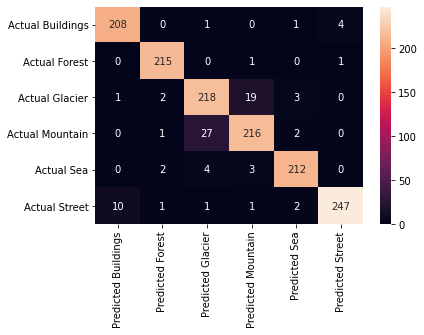

In [ ]:
# Reset test generator and network evaluation afterwards
# Fine-tuning only network heads
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
test_preds = vgg_intel_model.predict(test_generator)
test_labels = [np.argmax(pred) for pred in test_preds]
    
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, test_labels, labels=[0, 1, 2, 3, 4, 5]),index=["Actual Buildings", "Actual Forest", "Actual Glacier",
                                                                                                              "Actual Mountain", "Actual Sea", "Actual Street"],
columns=["Predicted Buildings", "Predicted Forest", "Predicted Glacier",
        "Predicted Mountain", "Predicted Sea", "Predicted Street"])
sns.heatmap(cm,annot=True,fmt="d")



labels = ["Buildings", "Forest", "Glacier", "Mountain", "Sea", "Street"]
classification_metrics = metrics.classification_report(test_generator.classes, test_labels, target_names=labels, output_dict=True)
print(classification_metrics)

In [ ]:
report = pd.DataFrame(classification_metrics)
report.to_csv('report.csv', index=None)

# **FASHION MULTICLASS IMAGE CLASSIFICATION**

In [ ]:
# Download kaggle dataset and unzip the file
# Source dataset apparel : trolukovich/apparel-images-dataset
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d trolukovich/apparel-images-dataset
!unzip apparel-images-dataset.zip

In [ ]:
# Create a new directory to store the merged files
os.makedirs('data/dataset')

In [ ]:
# Current folder path
current_folder = os.getcwd() 

# List of folders to be merged
dress_list_dir = ['black_dress', 'blue_dress', 'red_dress', 'white_dress']
pants_list_dir = ['black_pants', 'blue_pants', 'brown_pants', 'green_pants', 'red_pants', 'white_pants']
shirt_list_dir = ['black_shirt', 'blue_shirt', 'green_shirt']
shoes_list_dir = ['black_shoes', 'blue_shoes', 'brown_shoes', 'green_shoes', 'red_shoes', 'white_shoes']
shorts_list_dir = ['black_shorts', 'blue_shorts', 'brown_shorts', 'green_shorts', 'white_shorts']
  
# Enumerate on list_dir to get the 
# Content of all the folders ans store it in a dictionary
content_list = {}
for index, val in enumerate(shorts_list_dir):
    path = os.path.join(current_folder, val)
    content_list[shorts_list_dir[index] ] = os.listdir(path)


# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder_path):
      
    # Path
    path = os.path.join(parent_folder_path, folder_name)
      
    # Create the folder
    # 'new_folder' in
    # Parent_folder
    try: 
        
        # Mode of the folder
        mode = 0o777
  
        # Create folder
        os.mkdir(path, mode) 
          
    except OSError as error: 
        print(error)
  
# Folder in which all the content 
# Will be merged
dress_merge_folder = "data/dataset/dress"
pants_merge_folder = "data/dataset/pants"
shirt_merge_folder = "data/dataset/shirt"
shoes_merge_folder = "data/dataset/shoes"
shorts_merge_folder = "data/dataset/shorts"
  
# Merge_folder path - current_folder 
# + merge_folder
merge_folder_path = os.path.join(current_folder, shorts_merge_folder) 
  
# Create merge_folder if not exists
make_new_folder(shorts_merge_folder, current_folder)


# Import package
import shutil
import os

# Loop through the list of folders
for sub_dir in content_list:
  
    # Loop through the contents of the
    # List of folders
    for contents in content_list[sub_dir]:
  
        # Make the path of the content to move 
        path_to_content = sub_dir + "/" + contents  
  
        # Make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content )
  
        # Move the file
        shutil.move(dir_to_move, merge_folder_path)

# **DEVELOPING DATASETS INTO DATA TRAINING AND TESTING**

In [ ]:
path = 'data/dataset/'
filename = []
labels = []
fullpath = []
for path, subdirs, files in os.walk(path):
    for name in files:
        fullpath.append(os.path.join(path, name)) 
        labels.append(path.split('/')[-1])        
        filename.append(name)
df_apparel = pd.DataFrame({"path":fullpath,'filename':filename,"labels":labels})

In [ ]:
# Variables used in this data separation where x = data path and y = data labels
X= df_apparel['path']
y= df_apparel['labels']

# Split the initial dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Integrate into each dataframe
df_tr = pd.DataFrame({'path':X_train,
                      'labels':y_train,
                      'set':'train'})

df_te = pd.DataFrame({'path':X_test,
                      'labels':y_test,
                      'set':'test'})

In [ ]:
# Print the results above to see the length of the training and testing data sizes
print('train size', len(df_tr))
print('test size', len(df_te))

train size 9108
test size 2277


In [ ]:
# See the proportions in each set whether it's ok or there is still something you want to change
df_all = df_tr.append([df_te]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','labels']).size(),'\n')

print('===================================================== \n')

# Check the sample data
df_all.sample(5)


set    labels
test   dress      503
       pants      565
       shirt      354
       shoes      668
       shorts     187
train  dress     2067
       pants     2224
       shirt     1332
       shoes     2750
       shorts     735
dtype: int64 




,path,labels,set
524,data/dataset/pants/46cd96f27c6fbf7dc227d751843...,pants,train
1449,data/dataset/dress/0aaa34f91e22e721ed1d7e2e155...,dress,train
4617,data/dataset/shoes/9b821e065c50d952f00535de759...,shoes,train
11192,data/dataset/shirt/9aa5fd3e48618b5f15e5f77c2a6...,shirt,test
3800,data/dataset/shorts/6c242ce36130fda74912248031...,shorts,train


In [ ]:
# Calls the original dataset containing the entire image data that matches the label
data_source_path = "data/dataset/"
# Create a Dataset variable, which will later accommodate the data that has been divided into training and testing data
dataset_path = "apparel-dataset/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    
    # Detect filepath
    filepath = row['path']
    if os.path.exists(filepath) == False:
            filepath = os.path.join(data_source_path,row['labels'],row['image'].split('.')[0])            
    
    # Create a folder destination directory
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))
    
    # Specify the destination of the file
    destination_file_name = filepath.split('/')[-1]
    filedest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)
    
    # Copy files from source to destination
    if os.path.exists(filedest) == False:
        shutil.copy2(filepath,filedest)

0it [00:00, ?it/s]

# **EDA AND VIZUALIZATION SAMPLE IMAGE OF EACH CLASS**

In [ ]:
apparel_image = {}

path = "apparel-dataset"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "train")
for i in os.listdir(path_train):
    apparel_image[i] = os.listdir(os.path.join(path_train, i))

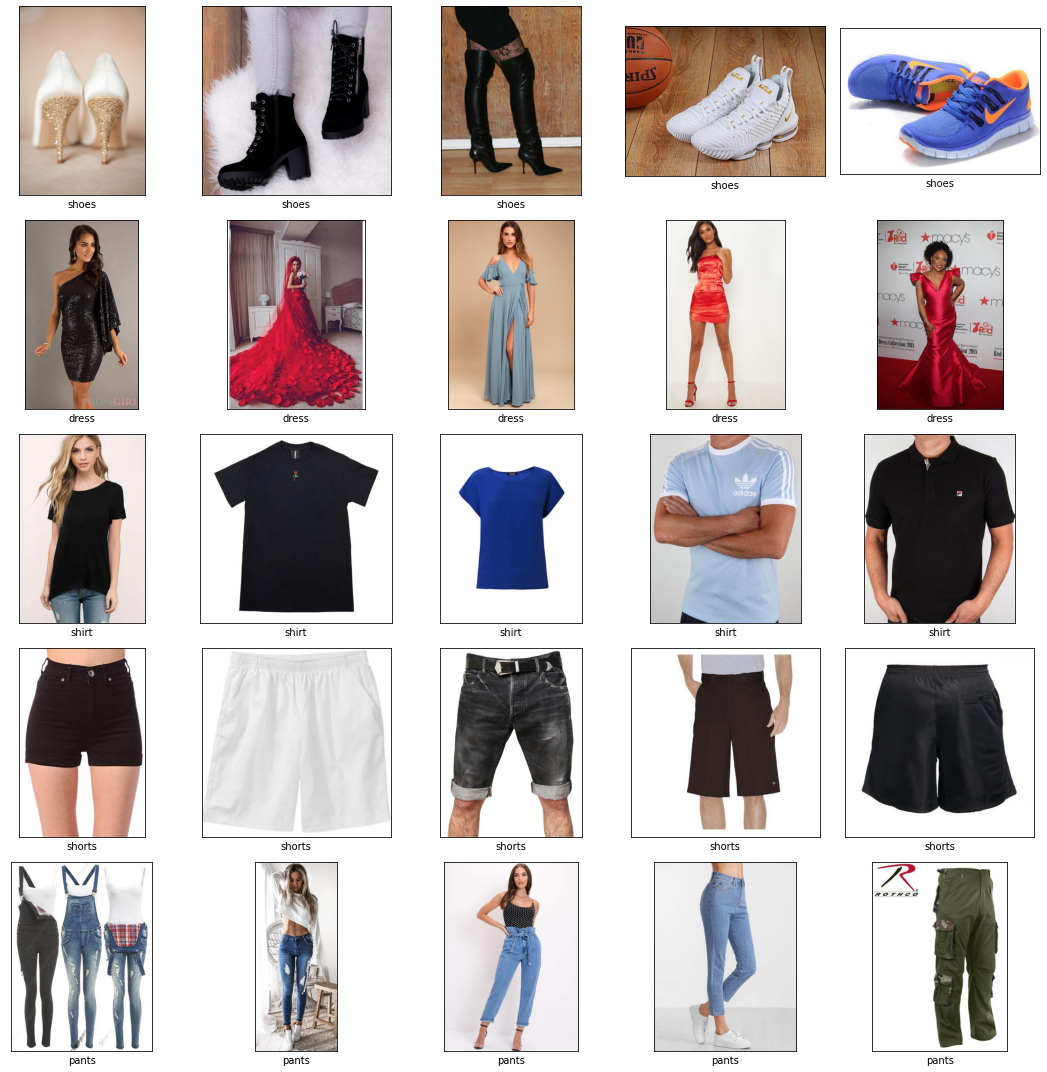

In [ ]:
# Randomly display 5 images under each of the 5 categories from the training data.
# You will see different images each time.

path_train= 'apparel-dataset/train/'

fig, axs = plt.subplots(len(apparel_image.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(apparel_image[item], 5)
    
    for j, image in enumerate(images):
        img = Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()
fig.savefig('apparel-train.png')

In [ ]:
filename = []
labels = []
fullpath = []
for path, subdirs, files in os.walk(path_train):
    for name in files:
        fullpath.append(os.path.join(path, name)) 
        labels.append(path.split('/')[-1])        
        filename.append(name)
df_apparel = pd.DataFrame({"path":fullpath,'filename':filename,"labels":labels})

In [ ]:
df_viz = df_apparel.groupby(["labels"])["labels"].count().reset_index(name="count")
df_viz

,labels,count
0,dress,2067
1,pants,2224
2,shirt,1332
3,shoes,2750
4,shorts,735


In [ ]:
fig = px.bar(df_viz, x = "labels", y = "count", width=600, height=400)
fig.show()

fig2 = px.pie(df_viz, values='count', names='labels', title='Proportion of each observed category', width=600, height=400)
fig2.show()

# **SET PARAMETER AND DIRECTORY TRAINING-TESTING**

In [ ]:
# Dimensions of our image
img_width, img_height = 224, 224  

train_data_dir = 'apparel-dataset/train/'
test_data_dir = 'apparel-dataset/test/'  
    
epochs = 20  # Number of epochs to train top model 
batch_size = 32  # Number of batch size to train top model 

# **IMAGE DATA GENERATOR**

In [ ]:
# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest",
                                   validation_split=0.2)
train_generator=train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode='categorical',
      subset='training',
      shuffle=False    
)
validation_generator=train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation',
      shuffle=False
)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
) 

Found 7288 images belonging to 5 classes.
Found 1820 images belonging to 5 classes.
Found 2277 images belonging to 5 classes.


# **BUILD MODEL InceptionResNetV2 AND DO TRAINING**

In [ ]:
# Load the inception resnetv2 model
base_model = InceptionResNetV2(
    weights = "imagenet",
    include_top = False, # Classification layer (output layer- sigmoid activations)
    input_shape=(img_width, img_height, 3)
)

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
# Freeze the basemodel weights, so these weights won't change during training
# Mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

In [ ]:
# Add advanced classification architecture to the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D(name = "Global_Average_Pool"))
model.add(Flatten(name = "flatten"))
model.add(Dense(512, activation = "relu", name = "dense_1"))
model.add(Dropout(0.3))
model.add(Dense(256, activation = "relu", name = "dense_2"))
model.add(Dropout(0.3))
model.add(Dense(5, activation = "softmax", name = "output"))

In [ ]:
# Compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer = RMSprop(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

In [ ]:
# Summary the architecture model
model.summary()

best_model_apparel = 'best_model_apparel.hdf5'

# Create model checkpoint to save best model weights
checkpointer = ModelCheckpoint(best_model_apparel,save_best_only = True,verbose = 1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Set the number of steps per epoch on the training data based on the calculation of the number of training data samples divided by the number of batch_size
training_steps_per_epoch = np.ceil(train_generator.samples // batch_size)
# Set the number of steps per epoch on data validation based on the calculation of the number of data validation samples divided by the number of batch_size
validation_steps_per_epoch = np.ceil(validation_generator.samples // batch_size)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=training_steps_per_epoch,
                    epochs = 20,
                    validation_data=validation_generator,
                    validation_steps=validation_steps_per_epoch,
                    callbacks=[checkpointer, early_stop])

# Evaluate model with training and validation data
(eval_loss, eval_accuracy) = model.evaluate(train_generator, batch_size=batch_size, verbose=1)
(eval_loss, eval_accuracy) = model.evaluate(validation_generator, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

# Save model
model.save('apparel_inceptionresnetv2.h5')  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
Global_Average_Pool (GlobalA (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

# **VISUALIZATION THE RESULT OF TRAINING**

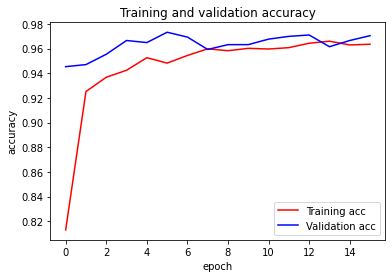

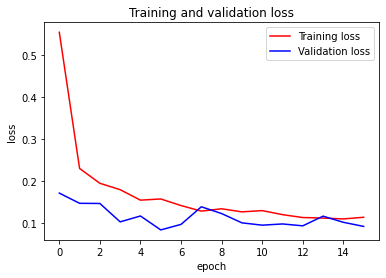




        loss  accuracy  val_loss  val_accuracy  epoch
0   0.554459  0.812982  0.172024      0.945312      0
1   0.230585  0.925165  0.147750      0.946987      1
2   0.195342  0.936742  0.147349      0.955357      2
3   0.180138  0.942393  0.103658      0.966518      3
4   0.155250  0.952591  0.117610      0.964844      4
5   0.158086  0.948181  0.084493      0.973214      5
6   0.142423  0.954383  0.097638      0.969308      6
7   0.129216  0.959757  0.139495      0.959263      7
8   0.134699  0.958241  0.123391      0.963170      8
9   0.127417  0.960171  0.101282      0.963170      9
10  0.130408  0.959620  0.095786      0.967634     10
11  0.120799  0.960722  0.098679      0.969866     11
12  0.113916  0.964305  0.094211      0.970982     12
13  0.112664  0.965959  0.117196      0.961496     13
14  0.110632  0.962927  0.102607      0.966518     14
15  0.114544  0.963479  0.092815      0.970424     15


In [ ]:
# Make a graph plot of the results of the accuracy of training validation and loss training validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

print('\n\n')
# Convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(history.history) 
hist_df['epoch'] = history.epoch
hist_df.to_csv('history.csv', index=None)
# Checkout result with print e.g.:    
print(hist_df)

# **TESTING WITH DATA TESTING**

[INFO] testing and evaluating...
{'Dress': {'precision': 0.9669902912621359, 'recall': 0.9900596421471173, 'f1-score': 0.9783889980353634, 'support': 503}, 'Pants': {'precision': 0.9700176366843033, 'recall': 0.9734513274336283, 'f1-score': 0.9717314487632509, 'support': 565}, 'Shirt': {'precision': 0.9830508474576272, 'recall': 0.9830508474576272, 'f1-score': 0.9830508474576272, 'support': 354}, 'Shoes': {'precision': 0.9969558599695586, 'recall': 0.9805389221556886, 'f1-score': 0.9886792452830189, 'support': 668}, 'Shorts': {'precision': 0.9456521739130435, 'recall': 0.93048128342246, 'f1-score': 0.9380053908355794, 'support': 187}, 'accuracy': 0.9771629336846728, 'macro avg': {'precision': 0.9725333618573337, 'recall': 0.9715164045233043, 'f1-score': 0.971971186074968, 'support': 2277}, 'weighted avg': {'precision': 0.9772769223596355, 'recall': 0.9771629336846728, 'f1-score': 0.9771641100124439, 'support': 2277}}


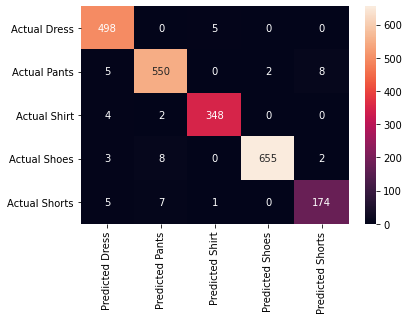

In [ ]:
# Reset test generator and network evaluation afterwards
print("[INFO] testing and evaluating...")
test_generator.reset()
test_preds = model.predict(test_generator)
test_labels = [np.argmax(pred) for pred in test_preds]
    
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, test_labels, labels=[0, 1, 2, 3, 4]),index=["Actual Dress", "Actual Pants", "Actual Shirt",
                                                                                                            "Actual Shoes", "Actual Shorts"],
columns=["Predicted Dress", "Predicted Pants", "Predicted Shirt",
        "Predicted Shoes", "Predicted Shorts"])
sns.heatmap(cm,annot=True,fmt="d")



labels = ["Dress", "Pants", "Shirt", "Shoes", "Shorts"]
classification_metrics = metrics.classification_report(test_generator.classes, test_labels, target_names=labels, output_dict=True)
print(classification_metrics)

In [ ]:
report = pd.DataFrame(classification_metrics)
report.to_csv('report.csv', index=None)